In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pointprocesses as ppr

In [3]:
import torch
from torch import nn

In [4]:
torch.manual_seed(1)

In [5]:
import os
import sys
import tqdm

In [6]:
# Add parent dir to interpreter path
nb_dir = os.path.split(os.getcwd())[0]
print("Notebook dir {:}".format(nb_dir))
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

Notebook dir /home/manifold/Documents/etudes/map511-p3a


In [7]:
for path in sys.path:
    print(path)


/home/manifold/Documents/etudes/map511-p3a/notebooks
/home/manifold/miniconda3/envs/pytorch/lib/python37.zip
/home/manifold/miniconda3/envs/pytorch/lib/python3.7
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/lib-dynload
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/pointprocesses-0.4.0-py3.7-linux-x86_64.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/torchvision-0.2.1-py3.7.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/IPython/extensions
/home/manifold/.ipython
/home/manifold/Documents/etudes/map511-p3a


# Synthetic data, Hawkes processes

The standard Hawkes model has an underlying intensity given by
$$
    \lambda_t = \lambda^0_t + \int_0^t g(t-s)\,dN_s
$$
where the function $g \geq 0$ is called the _kernel_.

Here we simulate Hawkes processes with kernel $g(t) = \alpha\exp(-\delta t)$.

In [8]:
def intensity_function_(t, lam0, alpha, beta, history):
    return lam0 + np.sum(alpha*beta*np.exp(-beta*(t - history))*(t >= history), axis=0)

intensity_function = np.vectorize(intensity_function_, excluded={4})

In [9]:
import itertools
mu = 1.0
tmax = 60.0
alpha = 0.2
beta  = 5

print("Expected avg evt no. %.3f" % (tmax*mu/(1.-alpha/beta)))

Expected avg evt no. 62.500


In [169]:
n_traj = 400
sample_trajectories = [
    torch.from_numpy(ppr.hawkes_exp(tmax, beta, mu, itertools.repeat(alpha)))
    for _ in range(n_traj)
]

print("Number of samples: \t\t%d" % len(sample_trajectories))
seq_lengths = torch.LongTensor([s.shape[0] for s in sample_trajectories])
input_size = seq_lengths.max().item()
print("Input size max. traj. length: \t%d" % input_size)
print("tmax = %.3f"  % tmax)
print("Empirical average %.3f" % seq_lengths.to(torch.float).mean().item())

data_tensor = nn.utils.rnn.pad_sequence(sample_trajectories).to(torch.float)
# Sort the sequences by decreasing length
seq_lengths, order_index_ = seq_lengths.sort(descending=True) # first sort the tensor of lengths
data_tensor = data_tensor[:, order_index_, :]
# Extract only times, append a beginning of sequence event
times_tensor = data_tensor[:,:,0]
# times_tensor = torch.cat((torch.zeros(1,times_tensor.shape[1]), times_tensor), dim=0)
# seq_lengths += 1

Number of samples: 		400
Input size max. traj. length: 	96
tmax = 60.000
Empirical average 63.603


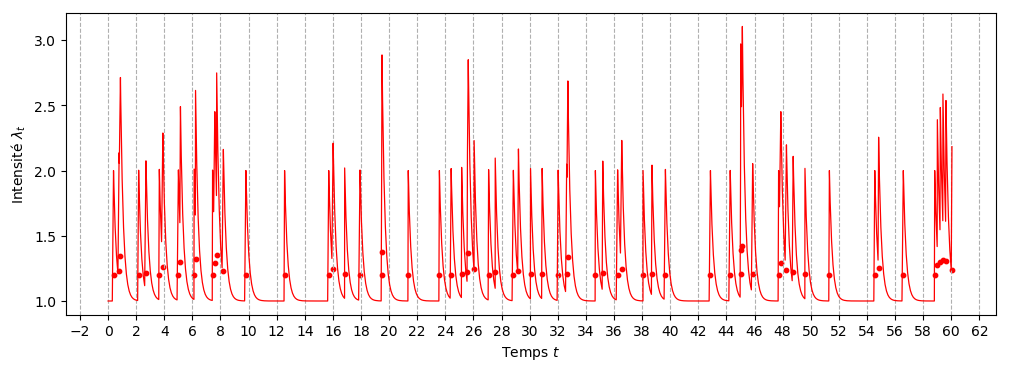

In [170]:
one_traj = sample_trajectories[1].numpy()
fig, ax = plt.subplots(1,1, figsize=(12,4), dpi=100)
ax.set_xlabel("Temps $t$")
ax.set_ylabel(r"Intensité $\lambda_t$")
t_arr = np.sort(np.append(np.linspace(0, tmax, 600), one_traj[:,0]))
ax.plot(t_arr, intensity_function(t_arr, mu, alpha, beta, one_traj[:,0]), 'r-', linewidth=0.9)
ax.xaxis.set_major_locator(mticker.MultipleLocator(2.))
scatter_opts = {
    "c": "r", "s": 11
}
ax.grid(True, axis='x', linestyle='--')
ax.scatter(one_traj[:,0], one_traj[:,1], c='r', s=10)

We will pad each sequence with 0s at the end.

Text(0, 0.5, 'Number')

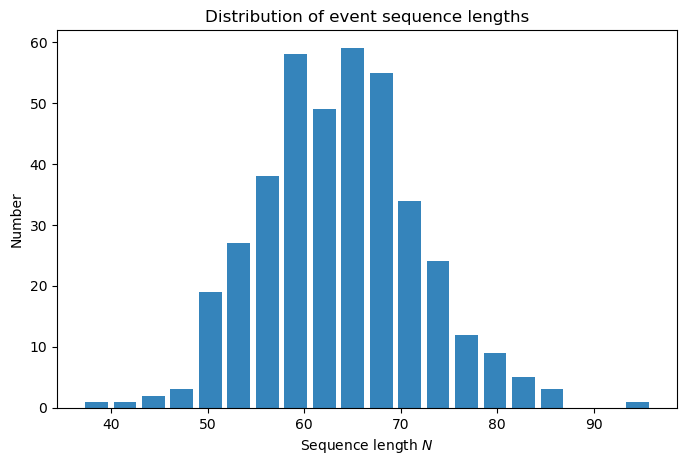

In [171]:
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
ax.hist(seq_lengths, bins=2*int(seq_lengths.size(0)**(2/5)), rwidth=0.8, alpha=0.9)
ax.set_title('Distribution of event sequence lengths')
ax.set_xlabel('Sequence length $N$')
ax.set_ylabel('Number')

In [172]:
data_tensor.shape

torch.Size([96, 400, 3])

In [173]:
packt = nn.utils.rnn.pack_padded_sequence(times_tensor, seq_lengths)

The first dimension is for the sequence length, the second for the sample number.

# Neural network

We are going for a recurrent neural structure that can learn from previous events. The intensity process of our neural model will be of the form

$$
    \lambda_t = \phi\left(W_{h\lambda} h(t)\right)
$$

with $\phi$ a positive-valued activation function (such as ReLU) and $h(t)\in\mathbb R^D$ a continuous hidden state, computed as
\begin{equation}
    h(t) = h_{i-1}e^{-\delta_i(t-t_{i-1})},\quad \forall t\in(t_{i-1},t_i]
\end{equation}

Network update formulas: the jump and decay parameters on $(t_i,t_{i+1}]$ are given by
$$
\begin{align*}
    h_{i+1}      &= \tanh(W_{hh}h(t_i) + b_{hh} + W_{ih}\Delta t_i + b_{ih}) \\
    \delta_{i+1} &= \sigma(W_d h(t_i) + b_d)
\end{align*}
$$

In [194]:
from torch import nn
import torch.nn.functional as F

In [201]:
from models.rnn import HawkesRNNModel

In [202]:
hidden_size = 12
model = HawkesRNNModel(hidden_size)
optimizer = torch.optim.SGD(model.parameters(), lr=0.002)

In [307]:
def train(model: HawkesRNNModel, sequence: torch.Tensor, seq_lengths: torch.Tensor):
    """
    Args:
        model: recurrent neural net model
        sequence: event sequence
        seq_lengths: sequence length
    """
    max_seq_length = seq_lengths[0]
    sequence = sequence[:max_seq_length]
    # Embed the sequence into the event arrival intervals
    sequence = torch.cat((torch.zeros_like(sequence[:1]), sequence))
    dt_sequence = sequence[1:] - sequence[:-1]
    # Trim the sequence to its real length
    packed_seq = nn.utils.rnn.pack_padded_sequence(dt_sequence, seq_lengths)
    # Reshape to a format the RNN can understand
    # N * batch
    max_batch_size = packed_seq.batch_sizes[0]
    # Data records
    hidd_decayed, decay = model.initialize_hidden(max_batch_size)
    hiddens = []
    decays = []
    for i in range(max_seq_length):
        batch_size = packed_seq.batch_sizes[i]
        dt_batch = dt_sequence[i, :batch_size]
        hidd_decayed = hidd_decayed[:batch_size]
        decay = decay[:batch_size]
        hidd, decay, hidd_decayed = model(dt_batch.unsqueeze(1), hidd_decayed, decay)
        hiddens.append(hidd)
        decays.append(decay)
    train_data = {
        "hidden": hiddens,
        "decay": decays
    }
    loss: Tensor = model.compute_loss(sequence.unsqueeze(2), packed_seq.batch_sizes, hiddens, decays, tmax)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()  # zero the gradients
    return train_data, loss.item()

In [311]:
# define training loop
train_size = 400
EPOCHS = 32
BATCH_SIZE = 32

In [312]:
loss_hist = []
for e in range(1, EPOCHS+1):
    # Epoch loop
    tr_loop_range = tqdm.tqdm(range(0, train_size, BATCH_SIZE), file=sys.stdout, desc="Epoch %d" % e)
    for i in tr_loop_range:
        sequence = times_tensor[:, i:(i+BATCH_SIZE)]
        train_info, loss = train(model, sequence, seq_lengths[i:(i+BATCH_SIZE)])
    loss_hist.append(loss)  # append the final loss of each epoch

Text(0, 0.5, 'Loss')

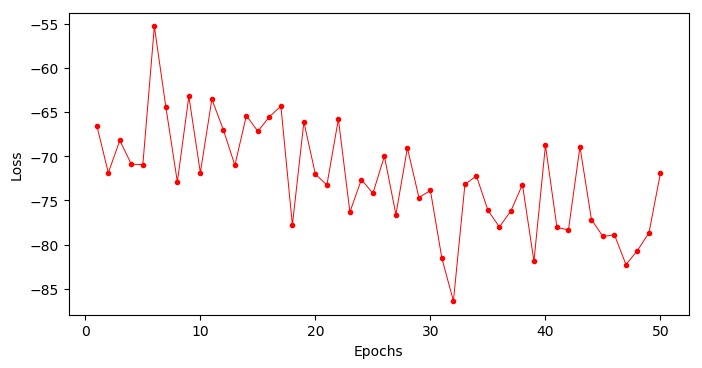

In [313]:
fig, ax = plt.subplots(1,1, figsize=(8,4), dpi=100)
epochs_range = list(range(1, EPOCHS+1))
ax.plot(epochs_range, loss_hist, color='red',
         linewidth=.7, marker='.')
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

In [41]:
# Build a statistic for the no. of events
gen_seq_lengths = []
n_gen_seq = 1000 # number of generated sequences
for i in range(n_gen_seq):
    gen_event_times, gen_event_intens, gen_event_decay = model.generate_sequence(tmax)
    gen_seq_lengths.append(len(gen_event_times) - 1)

In [42]:
2*int(n_gen_seq**(2/3))

198

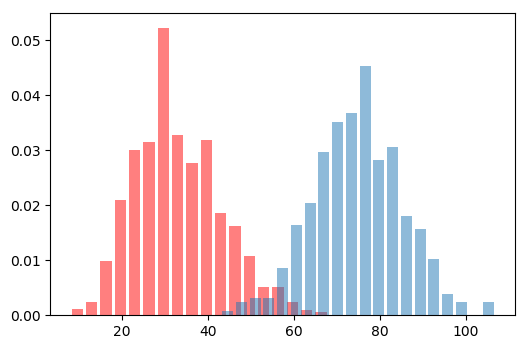

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(6,4), dpi=100)
_ = ax.hist(gen_seq_lengths, bins=2*int(n_gen_seq**(1/3)),
            rwidth=0.8, alpha=0.5, color='red', density=True)
_ = ax.hist(seq_lengths, bins=2*int(seq_lengths.size(0)**(2/5)),
            rwidth=0.8, alpha=0.5, density=True)

The number of events does not fit.

In [44]:
def plot_events_and_intensity(event_times, event_intensities):
    fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True,
                                   dpi=120,
                                   gridspec_kw = {'height_ratios':[3, 0.3]},
                                   figsize=(10,6))
    time_arr = np.linspace(0, tmax, 100)
    n_events = event_times.shape[0] - 1
    max_intens = max(event_intensities)
    min_intens = min(event_intensities)
    ax0.scatter(event_times[1:], event_intensities, s=8, alpha=0.7)
    ax0.set_ylabel("Event intensities $\lambda_t$")
    ax1.scatter(event_times[1:], [0.0 for _ in range(n_events)],
                alpha=0.4, s=16)
    ax1.set_xlabel("Time $t$")

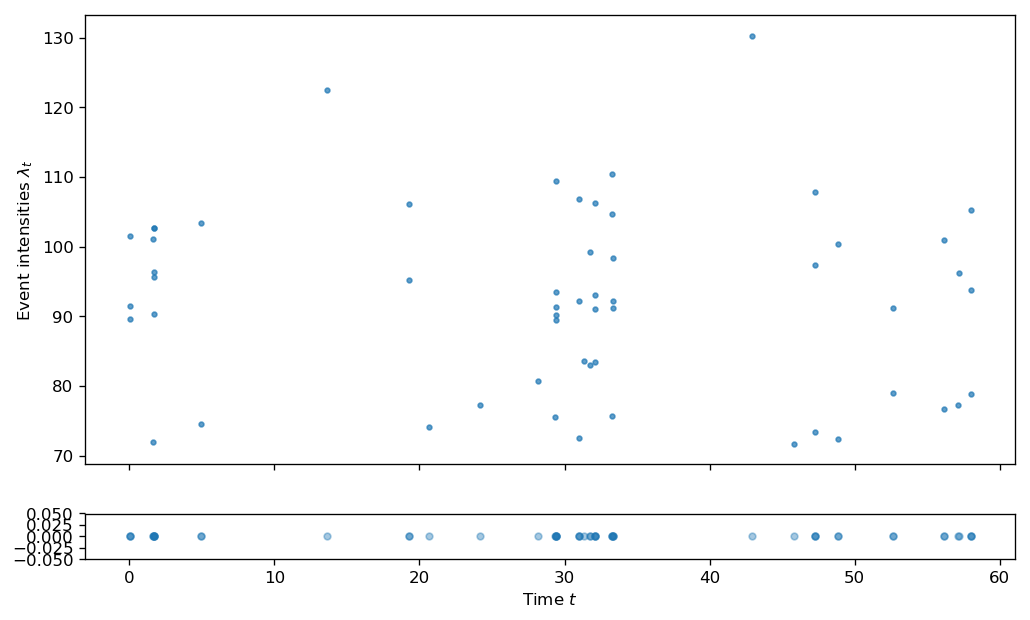

In [45]:
plot_events_and_intensity(gen_event_times, gen_event_intens)